In [1]:
import sys 
import os
sys.path.append(os.path.relpath("../code/"))
from data import *
from model import *

Using TensorFlow backend.
/home/jiamin/miniconda/envs/tf_gpu_cuda10/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jiamin/miniconda/envs/tf_gpu_cuda10/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jiamin/miniconda/envs/tf_gpu_cuda10/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])

Test Aaron's jpeg masks, convert to `npy` files

In [66]:
from PIL import Image
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from skimage import color
from skimage import io

def load_jpeg_scan(path):
    slices = []
    files = glob(path + '/*.jpg')
    files = natural_sort(files)
    for file in files:
        img = io.imread(file, as_gray=True)
        # Convert to Numpy Array
        x = img_to_array(img)
        # Normalize
        #x = (x - 128.0) / 128.0
        x = np.squeeze(x)
        slices.append(x)
    slices = np.array(slices)
    slices = np.flip(slices, 0) #masks were saved in reverse order
    return slices

i = 0
for imgtype in ["01","02","10","00"]:
    n = 'E3062'
    PATIENT_ID = n
    IMG_TYPE = imgtype #for water, "02" for fat, "10" for fat frac, "00" for r2*
    DATA_PATH = "../data/Vertebrae/"+PATIENT_ID+"/*"+IMG_TYPE+"/"
    MASK_PATH = "../data/Vertebrae/"+PATIENT_ID+"/mask*/" # folders are either 'mask' or 'masks'
    OUTPUT_PATH = "../npy_data/test/"
    print("Processing patient ", n)
    patient = load_scan(DATA_PATH)
    imgs = get_pixels(patient)
    #print(imgs.shape)
    if (imgs.shape[0] != 20): # some patients don't have 20 slices acquired
        print("Patient %s doesn't have 20 slices" % n)
    else:
        np.save(OUTPUT_PATH + "imgs/"+str(i)+"/fullimages_%s.npy" % (PATIENT_ID), imgs)
        patient_mask = load_jpeg_scan(MASK_PATH)
        masks = patient_mask
        #print(masks.shape)
        np.save(OUTPUT_PATH + "labels/fullimages_%s.npy" % (PATIENT_ID), masks)
    i+=1
    

Processing patient  E3062
Processing patient  E3062
Processing patient  E3062
Processing patient  E3062


In [67]:
# Parameters
width = 256
height = 256
slices = 20
channels = 4
train_path = '../npy_data/train/'
test_path = '../npy_data/test/'

id_ = 'fullimages_E3062.npy'
X = np.zeros((slices, height, width, channels), dtype=np.uint16)
y = np.zeros((slices, height, width, 1), dtype=np.bool)

for ch in range(channels):
    i = 0
    path = test_path + 'imgs/' + str(ch) + '/' + id_
    img = np.load(path)[:,:,:]
    mask = np.zeros((height, width, 1), dtype=np.bool)
    maskpath = test_path + 'labels/' + id_
    mask_ = np.load(maskpath)[:,:,:,np.newaxis]
    mask = np.maximum(mask, mask_)
    for i in range(slices):
        X[i,:,:,ch] = img[i]
        y[i] = mask[i]
        i+=1


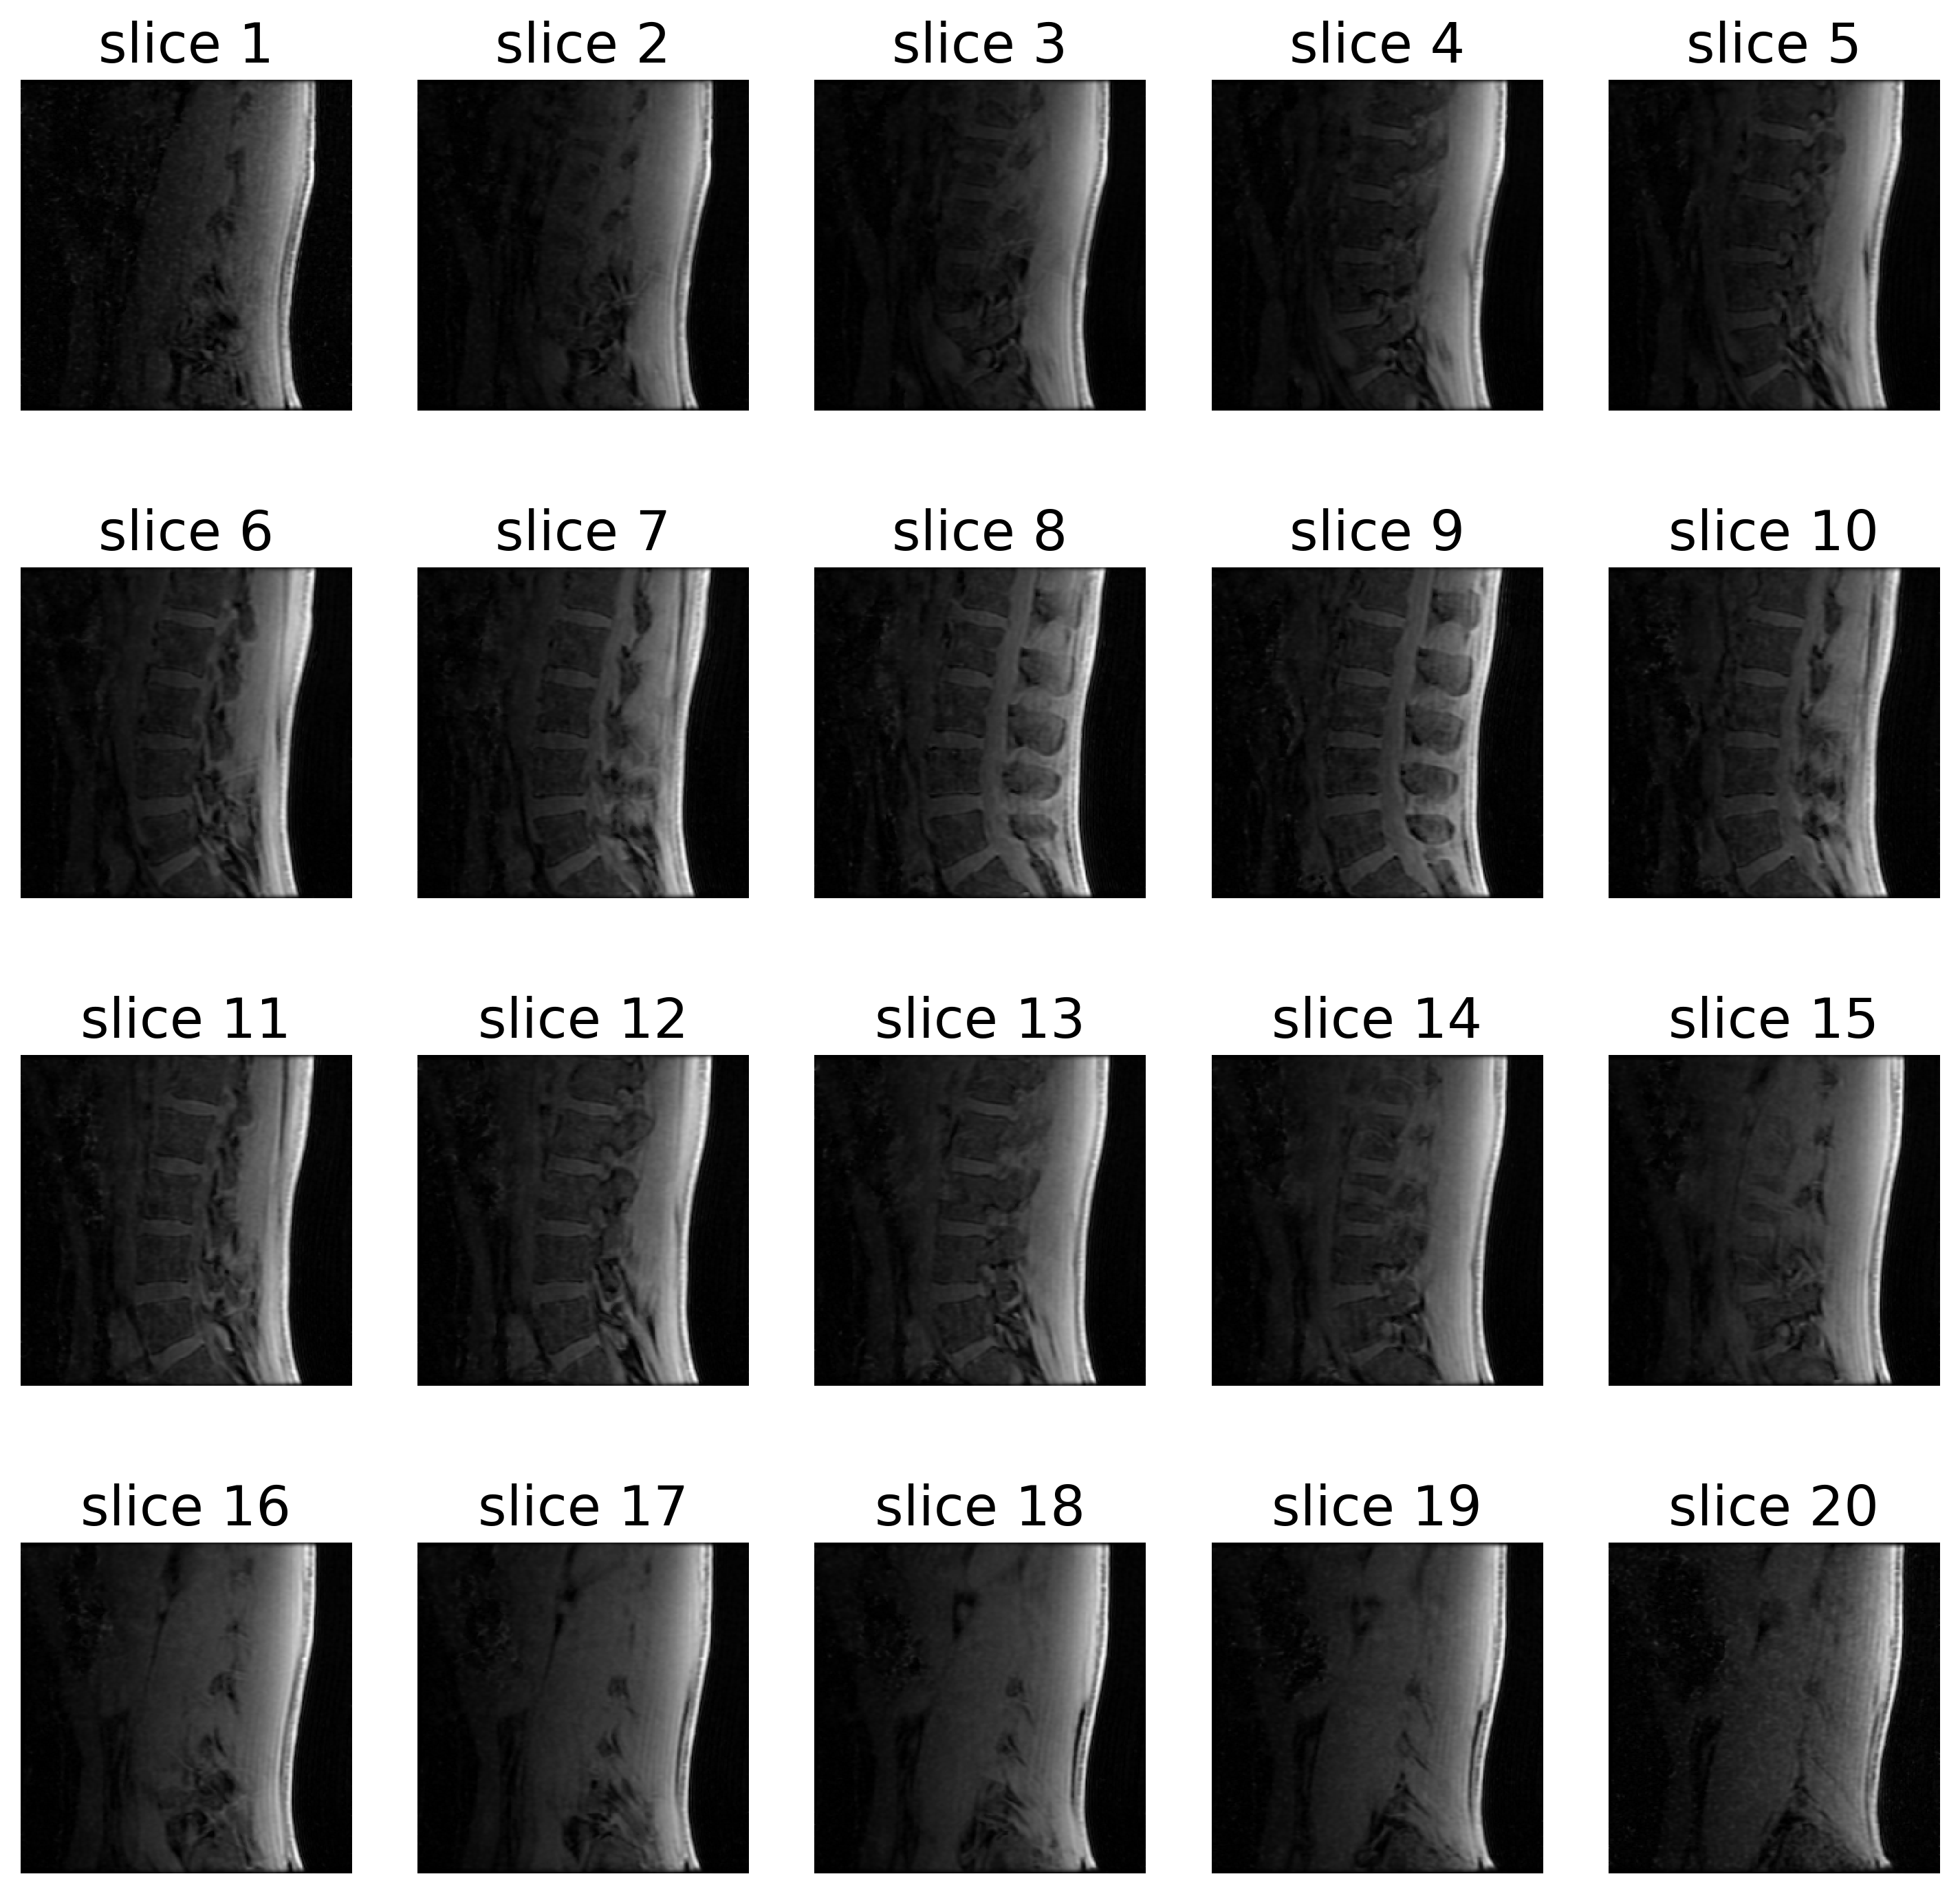

In [68]:
X.shape
sample_stack(X[...,0])

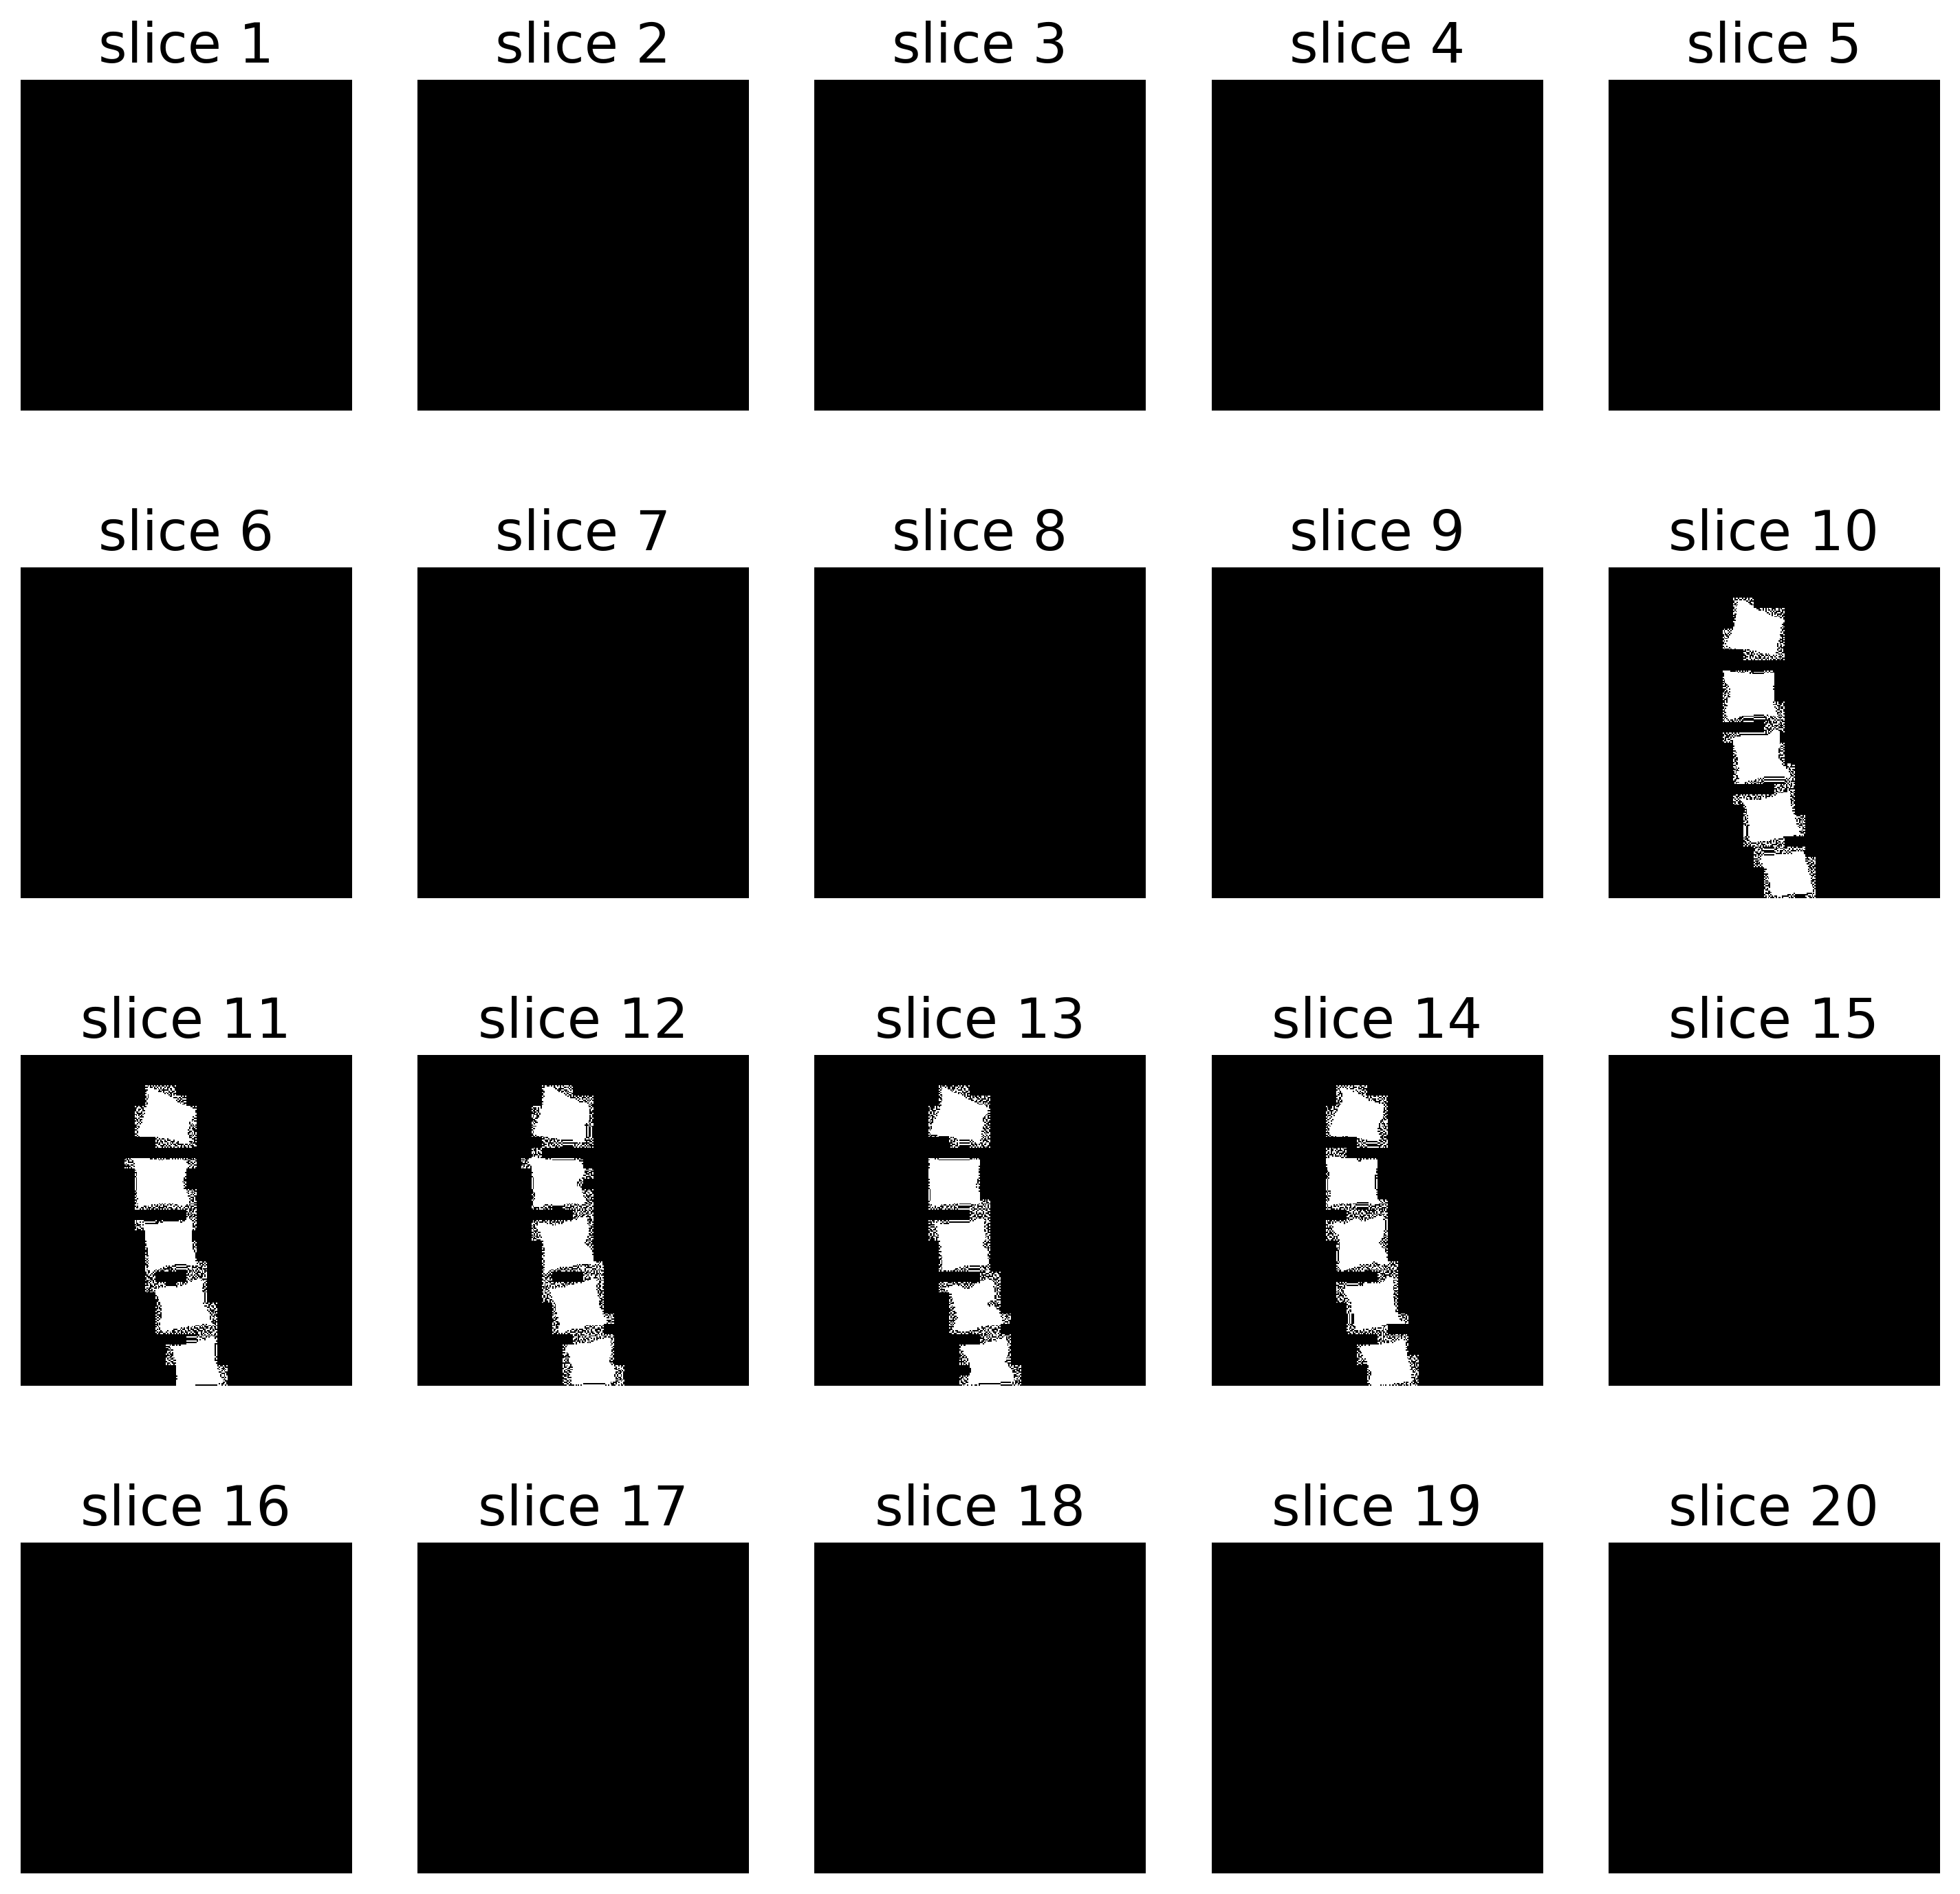

In [69]:
y.shape
sample_stack(y.squeeze())